# senadores - EDA e modelo produção parlamentar

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 8))
import janitor

import datetime

import sqlite3 as sql

from sklearn.cluster import KMeans
from numpy import unique
from numpy import where

#nomalizing data to its std (x_new= x/std(x))
from scipy.cluster.vq import whiten

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity="all"

## EDA Básico

In [2]:
!ls ../../dados/sql

base_completa.db  Normalização_03.ipynb


In [3]:
#Dados de parlamentares
con = sql.connect("../../dados/sql/base_completa.db")
df_sen=pd.read_sql("select * from senadores_cadastro",con)
df_sen_prop=pd.read_sql("select * from senadores_propostas",con)
df_sen_sess=pd.read_sql("select * from senadores_sessoes",con)
df_sen_vot=pd.read_sql("select * from senadores_votacoes",con)
df_diap=pd.read_sql("select * from diap",con)
con.close()

In [4]:
df_sen.info()
df_diap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CPF                      79 non-null     object 
 1   NM_CANDIDATO_x           79 non-null     object 
 2   DT_NASCIMENTO            79 non-null     object 
 3   SG_UF_NASCIMENTO         79 non-null     object 
 4   NM_MUNICIPIO_NASCIMENTO  79 non-null     object 
 5   DS_GENERO                79 non-null     object 
 6   DS_GRAU_INSTRUCAO        79 non-null     object 
 7   DS_ESTADO_CIVIL          79 non-null     object 
 8   DS_COR_RACA              79 non-null     object 
 9   DS_OCUPACAO              79 non-null     object 
 10  VL_BENS                  79 non-null     float64
 11  ANO_ELEICAO              79 non-null     int64  
 12  DS_CARGO                 79 non-null     object 
 13  SG_PARTIDO               79 non-null     object 
 14  SG_UE                    79 

In [5]:
df_sen.drop(columns=["NM_CANDIDATO_y","NM_CANDIDATO_x","NM_MUNICIPIO_NASCIMENTO","SQ_CANDIDATO",
                           "IDADE","NM_EMAIL","URL_SENADO","FOTO_URI","URL_PARTICULAR"], inplace=True)

In [6]:
df_sen.sample(5)

,CPF,DT_NASCIMENTO,SG_UF_NASCIMENTO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,VL_BENS,ANO_ELEICAO,...,SG_PARTIDO,SG_UE,NM_URNA_CANDIDATO,VR_DESPESA_CONTRATADA,followers_count,tweets,ID_SENADO,ID_PUB,MESA,LIDERANCA
15,00135968372,01/08/1942,CE,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,ADVOGADO,1256546.67,2014,...,PTB,PI,ELMANO - O VEIN TRABALHADOR,2472971.60,NaN,NaN,5531,810,Não,Sim
38,07654871449,23/04/1951,PE,MASCULINO,SUPERIOR COMPLETO,CASADO(A),PARDA,ENGENHEIRO,1999315.15,2018,...,DEM,RR,CHICO RODRIGUES,845119.85,467.0,163.0,470,815,Não,Sim
51,21840571187,20/01/1961,SP,MASCULINO,ENSINO FUNDAMENTAL INCOMPLETO,DIVORCIADO(A),BRANCA,JORNALEIRO,95000.00,2018,...,PRP,GO,JORGE KAJURU,209591.06,274458.0,59703.0,5895,863,Não,Não
11,07588615249,13/08/1958,SP,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,ENGENHEIRO,1650485.60,2014,...,PSD,AM,OMAR AZIZ,4412079.43,56545.0,2186.0,5525,803,Não,Não
26,47555882604,09/05/1961,MG,MASCULINO,SUPERIOR COMPLETO,SOLTEIRO(A),BRANCA,SERVIDOR PÚBLICO ESTADUAL,562000.00,2014,...,PSDB,MG,ANTONIO ANASTASIA,18083083.27,63838.0,6516.0,5529,898,Sim,Não


In [7]:
df_sen_prop.shape
df_sen_prop.info()
df_sen_prop.head()

(2061, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061 entries, 0 to 2060
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PROP_ID           2061 non-null   object
 1   ID_SENADO         2061 non-null   object
 2   TIPO              2061 non-null   object
 3   TIPO_DESC         2061 non-null   object
 4   PROP_ANO          2061 non-null   int64 
 5   PROP_DATA         2061 non-null   object
 6   PROP_DS_MATERIA   2061 non-null   object
 7   PROP_NATUREZA     2061 non-null   object
 8   PROP_STATUS_DATA  1966 non-null   object
 9   PROP_STATUS       1966 non-null   object
dtypes: int64(1), object(9)
memory usage: 161.1+ KB


,PROP_ID,ID_SENADO,TIPO,TIPO_DESC,PROP_ANO,PROP_DATA,PROP_DS_MATERIA,PROP_NATUREZA,PROP_STATUS_DATA,PROP_STATUS
0,135084,5929,RQS,REQUERIMENTO,2019,2019-02-02,RQS 1/2019,NAOCAT_CONTEUDO_NATUREZA_ESPECIFICA,2019-02-02,PRJDA
1,135085,5012,RQS,REQUERIMENTO,2019,2019-02-02,RQS 2/2019,NAOCAT_CONTEUDO_NATUREZA_ESPECIFICA,2019-02-02,PRJDA
2,135104,5008,RQS,REQUERIMENTO,2019,2019-02-06,RQS 4/2019,MISSAO,2019-02-12,APRVD
3,135106,90,RQS,REQUERIMENTO,2019,2019-02-07,RQS 5/2019,MISSAO,2019-02-07,DEFERD
4,135107,374,PDL,PROJETO DE DECRETO LEGISLATIVO,2019,2019-01-04,PDL 16/2019,SUSTACAO_ATO_PODER_EXECUTIVO,2019-03-12,RELATOR


## Percentual de cada tipo

In [8]:
df_prop_tipos=pd.DataFrame(df_sen_prop["TIPO_DESC"].value_counts())
df_prop_tipos.rename(columns={"TIPO_DESC":"QUANT"}, inplace=True)
df_prop_tipos.index.name="TIPO_DESC"
df_prop_tipos

,QUANT
TIPO_DESC,
REQUERIMENTO,1138
PROJETO DE LEI,703
PROPOSTA DE EMENDA À CONSTITUIÇÃO,71
PROJETO DE RESOLUÇÃO DO SENADO,56
PROJETO DE LEI COMPLEMENTAR,51
PROJETO DE DECRETO LEGISLATIVO,34
"OFICIO ""S""",2
PROPOSTA DE FISCALIZAÇÃO E CONTROLE,2
INDICAÇÃO,1


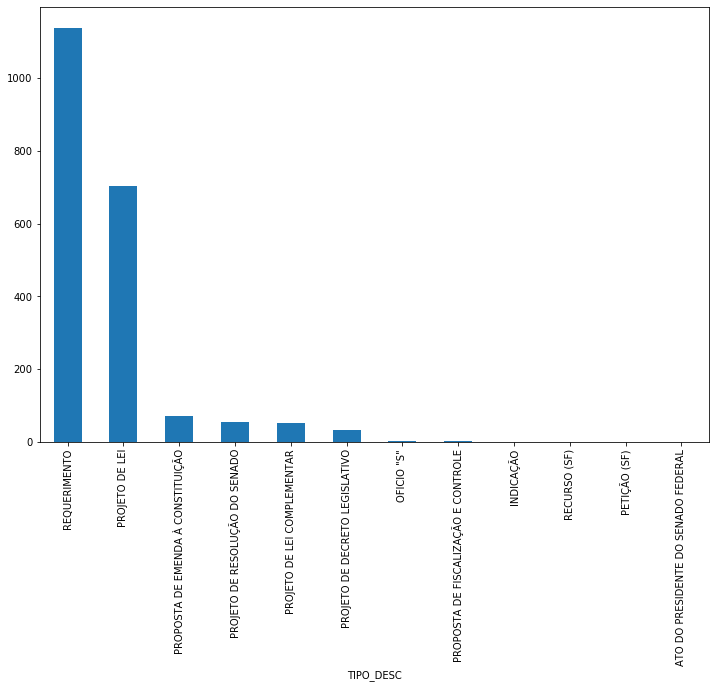

In [9]:
f = lambda x: x/x.sum()
df_prop_tipos["PERC"]=df_prop_tipos.apply(f)
df_prop_tipos["QUANT"].plot(kind="bar")

## Para cada senador

### Total de propostas

pandas.core.series.Series

TIPO,ATS,INS,OFS,PDL,PEC,PET,PFS,PL,PLP,PRS,R.S,REQ,RQS,PROP_TOTAL
ID_SENADO,,,,,,,,,,,,,,
825,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,0.0,0.0,48.0,23.0,84.0
5012,0.0,0.0,0.0,5.0,2.0,0.0,0.0,12.0,2.0,3.0,0.0,23.0,24.0,71.0
4770,0.0,0.0,0.0,0.0,2.0,0.0,0.0,11.0,1.0,3.0,0.0,30.0,21.0,68.0
5953,0.0,0.0,0.0,3.0,3.0,0.0,0.0,28.0,0.0,1.0,0.0,21.0,8.0,64.0
5748,0.0,0.0,0.0,0.0,4.0,0.0,0.0,41.0,2.0,0.0,0.0,9.0,8.0,64.0


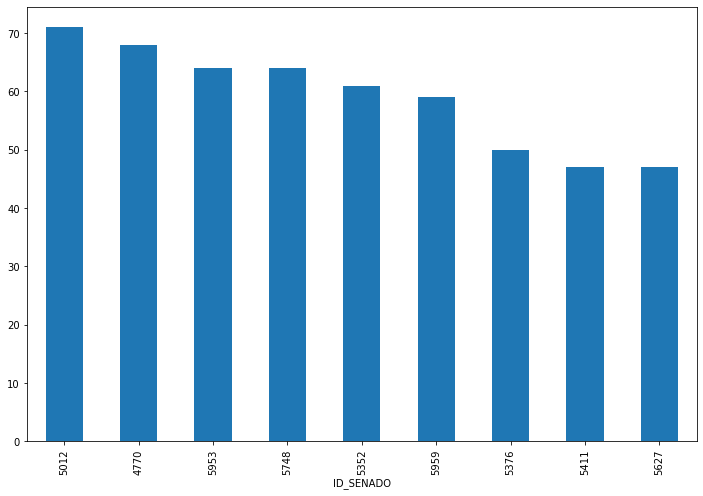

In [10]:
x=df_sen_prop.groupby("ID_SENADO")["TIPO"].value_counts()
type(x)
df_sen_prop_tipos=x.unstack().fillna(0)
df_sen_prop_tipos["PROP_TOTAL"]=df_sen_prop_tipos.sum(axis=1)

df_sen_prop_tipos.sort_values("PROP_TOTAL", inplace=True, ascending=False)
df_sen_prop_tipos.head()
df_sen_prop_tipos["PROP_TOTAL"].iloc[1:10].plot(kind="bar")

In [11]:
df_sen_prop_tipos=df_sen_prop_tipos[["REQ","PEC","PL"]]

In [12]:
df_sen_prod=pd.merge(df_sen,df_sen_prop_tipos, how="left", on="ID_SENADO")
df_sen_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    79 non-null     object 
 1   DT_NASCIMENTO          79 non-null     object 
 2   SG_UF_NASCIMENTO       79 non-null     object 
 3   DS_GENERO              79 non-null     object 
 4   DS_GRAU_INSTRUCAO      79 non-null     object 
 5   DS_ESTADO_CIVIL        79 non-null     object 
 6   DS_COR_RACA            79 non-null     object 
 7   DS_OCUPACAO            79 non-null     object 
 8   VL_BENS                79 non-null     float64
 9   ANO_ELEICAO            79 non-null     int64  
 10  DS_CARGO               79 non-null     object 
 11  SG_PARTIDO             79 non-null     object 
 12  SG_UE                  79 non-null     object 
 13  NM_URNA_CANDIDATO      79 non-null     object 
 14  VR_DESPESA_CONTRATADA  79 non-null     float64
 15  follower

In [13]:
df=pd.merge(df_sen_prod,df_diap, how="left", on="CPF")
#df=df_sen_prod

In [14]:
df.info()
df.fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    79 non-null     object 
 1   DT_NASCIMENTO          79 non-null     object 
 2   SG_UF_NASCIMENTO       79 non-null     object 
 3   DS_GENERO              79 non-null     object 
 4   DS_GRAU_INSTRUCAO      79 non-null     object 
 5   DS_ESTADO_CIVIL        79 non-null     object 
 6   DS_COR_RACA            79 non-null     object 
 7   DS_OCUPACAO            79 non-null     object 
 8   VL_BENS                79 non-null     float64
 9   ANO_ELEICAO            79 non-null     int64  
 10  DS_CARGO               79 non-null     object 
 11  SG_PARTIDO             79 non-null     object 
 12  SG_UE                  79 non-null     object 
 13  NM_URNA_CANDIDATO      79 non-null     object 
 14  VR_DESPESA_CONTRATADA  79 non-null     float64
 15  follower

In [15]:
hoje=datetime.datetime.now()
df["IDADE"]=df["DT_NASCIMENTO"].apply(lambda x:(hoje-datetime.datetime.strptime(x, '%d/%m/%Y')).days//(365.25))

In [16]:
df.sample(5)

,CPF,DT_NASCIMENTO,SG_UF_NASCIMENTO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,VL_BENS,ANO_ELEICAO,...,REQ,PEC,PL,mandatos,cabeças,debatedor,articulador,formulador,negociador,IDADE
32,40448118149,05/09/1961,MS,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,MÉDICO,3225570.89,2018,...,20.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0
8,34195491991,07/12/1956,SC,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),BRANCA,ADMINISTRADOR,1095874.10,2014,...,13.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0
36,31966810334,25/09/1972,CE,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),PARDA,EMPRESÁRIO,36397417.26,2018,...,17.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0
18,61330345134,02/02/1962,GO,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),BRANCA,SENADOR,4131891.79,2014,...,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0
16,43461107204,26/03/1978,AC,MASCULINO,SUPERIOR COMPLETO,CASADO(A),PARDA,DEPUTADO,514392.07,2014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0


In [17]:
df.columns

Index(['CPF', 'DT_NASCIMENTO', 'SG_UF_NASCIMENTO', 'DS_GENERO',
       'DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL', 'DS_COR_RACA', 'DS_OCUPACAO',
       'VL_BENS', 'ANO_ELEICAO', 'DS_CARGO', 'SG_PARTIDO', 'SG_UE',
       'NM_URNA_CANDIDATO', 'VR_DESPESA_CONTRATADA', 'followers_count',
       'tweets', 'ID_SENADO', 'ID_PUB', 'MESA', 'LIDERANCA', 'REQ', 'PEC',
       'PL', 'mandatos', 'cabeças', 'debatedor', 'articulador', 'formulador',
       'negociador', 'IDADE'],
      dtype='object')

In [18]:
df.columns
df.drop(columns="DS_CARGO", axis=1, inplace=True)

Index(['CPF', 'DT_NASCIMENTO', 'SG_UF_NASCIMENTO', 'DS_GENERO',
       'DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL', 'DS_COR_RACA', 'DS_OCUPACAO',
       'VL_BENS', 'ANO_ELEICAO', 'DS_CARGO', 'SG_PARTIDO', 'SG_UE',
       'NM_URNA_CANDIDATO', 'VR_DESPESA_CONTRATADA', 'followers_count',
       'tweets', 'ID_SENADO', 'ID_PUB', 'MESA', 'LIDERANCA', 'REQ', 'PEC',
       'PL', 'mandatos', 'cabeças', 'debatedor', 'articulador', 'formulador',
       'negociador', 'IDADE'],
      dtype='object')

In [19]:
df.shape
df.info()
df.sample(10)

(79, 30)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    79 non-null     object 
 1   DT_NASCIMENTO          79 non-null     object 
 2   SG_UF_NASCIMENTO       79 non-null     object 
 3   DS_GENERO              79 non-null     object 
 4   DS_GRAU_INSTRUCAO      79 non-null     object 
 5   DS_ESTADO_CIVIL        79 non-null     object 
 6   DS_COR_RACA            79 non-null     object 
 7   DS_OCUPACAO            79 non-null     object 
 8   VL_BENS                79 non-null     float64
 9   ANO_ELEICAO            79 non-null     int64  
 10  SG_PARTIDO             79 non-null     object 
 11  SG_UE                  79 non-null     object 
 12  NM_URNA_CANDIDATO      79 non-null     object 
 13  VR_DESPESA_CONTRATADA  79 non-null     float64
 14  followers_count        79 non-null     float64
 15  tweets  

,CPF,DT_NASCIMENTO,SG_UF_NASCIMENTO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,VL_BENS,ANO_ELEICAO,...,REQ,PEC,PL,mandatos,cabeças,debatedor,articulador,formulador,negociador,IDADE
5,90671953753,29/01/1966,RJ,MASCULINO,SUPERIOR INCOMPLETO,SEPARADO(A) JUDICIALMENTE,PARDA,DEPUTADO,1311189.82,2014,...,22.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0
77,01720486727,15/06/1971,ES,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),BRANCA,OUTROS,737934.91,2018,...,11.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0
45,11078685487,16/09/1955,AL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,SENADOR,1865778.62,2018,...,0.0,0.0,0.0,4.0,23.0,0.0,1.0,0.0,0.0,64.0
23,05985234568,28/08/1947,BA,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,MÉDICO,2481575.01,2014,...,4.0,0.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,73.0
29,86364561772,20/06/1966,ES,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,POLICIAL CIVIL,1134302.04,2018,...,21.0,3.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0
50,20912340282,10/11/1964,AP,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),BRANCA,"TÉCNICO DE ELETRICIDADE, ELETRÔNICA E TELECOMU...",159860.00,2018,...,2.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0
68,31340261120,28/04/1966,TO,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),BRANCA,OUTROS,0.00,2018,...,8.0,1.0,4.0,1.0,6.0,0.0,1.0,0.0,0.0,54.0
36,31966810334,25/09/1972,CE,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),PARDA,EMPRESÁRIO,36397417.26,2018,...,17.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0
72,14272954091,14/09/1950,RS,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,DEPUTADO,8390578.91,2018,...,8.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0
66,11268786934,21/12/1947,SC,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,DEPUTADO,3113478.01,2018,...,8.0,0.0,3.0,2.0,8.0,0.0,0.0,0.0,1.0,72.0


In [20]:
df.info()
df.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    79 non-null     object 
 1   DT_NASCIMENTO          79 non-null     object 
 2   SG_UF_NASCIMENTO       79 non-null     object 
 3   DS_GENERO              79 non-null     object 
 4   DS_GRAU_INSTRUCAO      79 non-null     object 
 5   DS_ESTADO_CIVIL        79 non-null     object 
 6   DS_COR_RACA            79 non-null     object 
 7   DS_OCUPACAO            79 non-null     object 
 8   VL_BENS                79 non-null     float64
 9   ANO_ELEICAO            79 non-null     int64  
 10  SG_PARTIDO             79 non-null     object 
 11  SG_UE                  79 non-null     object 
 12  NM_URNA_CANDIDATO      79 non-null     object 
 13  VR_DESPESA_CONTRATADA  79 non-null     float64
 14  followers_count        79 non-null     float64
 15  tweets  

,VL_BENS,ANO_ELEICAO,VR_DESPESA_CONTRATADA,followers_count,tweets,REQ,PEC,PL,mandatos,cabeças,debatedor,articulador,formulador,negociador,IDADE
count,7.900000e+01,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00
mean,1.230221e+07,2016.63,2786541.03,131545.58,9020.23,7.99,0.90,8.53,0.52,2.00,0.08,0.11,0.11,0.06,59.81
std,5.093624e+07,1.91,2828442.88,373706.20,16998.39,8.69,1.07,9.02,0.81,4.61,0.27,0.32,0.32,0.25,11.75
min,0.000000e+00,2014.00,35585.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,37.00
25%,6.673189e+05,2014.00,1053250.96,5840.00,1013.00,2.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,50.50
50%,1.865779e+06,2018.00,2253475.38,16750.00,4160.00,5.00,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,59.00
75%,4.310509e+06,2018.00,3270782.83,83371.50,10653.50,11.00,1.00,11.00,1.00,1.00,0.00,0.00,0.00,0.00,69.00
max,3.890197e+08,2018.00,18083083.27,2541590.00,119551.00,48.00,4.00,41.00,4.00,26.00,1.00,1.00,1.00,1.00,86.00


In [21]:
#df.fillna(0, inplace=True)
#df.info()

In [22]:
df.describe(include=np.object)

,CPF,DT_NASCIMENTO,SG_UF_NASCIMENTO,DS_GENERO,DS_GRAU_INSTRUCAO,DS_ESTADO_CIVIL,DS_COR_RACA,DS_OCUPACAO,SG_PARTIDO,SG_UE,NM_URNA_CANDIDATO,ID_SENADO,ID_PUB,MESA,LIDERANCA
count,79,79,79,79,79,79,79,79,79,79,79,79,79,79,79
unique,79,79,26,2,4,5,3,24,21,27,79,77,77,3,3
top,06651127268,23/04/1951,SP,MASCULINO,SUPERIOR COMPLETO,CASADO(A),BRANCA,DEPUTADO,PSDB,AP,RANDOLFE,0,0,Não,Não
freq,1,1,9,68,64,59,61,21,8,3,1,3,3,65,39


In [23]:
df.info()
unicos=df.nunique()
unicos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    79 non-null     object 
 1   DT_NASCIMENTO          79 non-null     object 
 2   SG_UF_NASCIMENTO       79 non-null     object 
 3   DS_GENERO              79 non-null     object 
 4   DS_GRAU_INSTRUCAO      79 non-null     object 
 5   DS_ESTADO_CIVIL        79 non-null     object 
 6   DS_COR_RACA            79 non-null     object 
 7   DS_OCUPACAO            79 non-null     object 
 8   VL_BENS                79 non-null     float64
 9   ANO_ELEICAO            79 non-null     int64  
 10  SG_PARTIDO             79 non-null     object 
 11  SG_UE                  79 non-null     object 
 12  NM_URNA_CANDIDATO      79 non-null     object 
 13  VR_DESPESA_CONTRATADA  79 non-null     float64
 14  followers_count        79 non-null     float64
 15  tweets  

CPF                      79
DT_NASCIMENTO            79
SG_UF_NASCIMENTO         26
DS_GENERO                 2
DS_GRAU_INSTRUCAO         4
DS_ESTADO_CIVIL           5
DS_COR_RACA               3
DS_OCUPACAO              24
VL_BENS                  79
ANO_ELEICAO               2
SG_PARTIDO               21
SG_UE                    27
NM_URNA_CANDIDATO        79
VR_DESPESA_CONTRATADA    79
followers_count          69
tweets                   69
ID_SENADO                77
ID_PUB                   77
MESA                      3
LIDERANCA                 3
REQ                      27
PEC                       5
PL                       28
mandatos                  5
cabeças                  13
debatedor                 2
articulador               2
formulador                2
negociador                2
IDADE                    32
dtype: int64

## Defindo variaveis categóricas numericas

In [24]:
def analisa_variaveis(df,variaveis,nunicas):
    lista=[]
    unicos=df[variaveis].nunique()
    for variavel in unicos.index:
        quant=unicos.loc[variavel]
        if quant <= nunicas:
            lista.append(variavel)
            print("Variavel {}, {} ocorrências únicas".format(variavel,quant))
            print(df[variavel].sort_values().unique())
    return lista

In [25]:
variaveis_numericas= df.select_dtypes(include=[np.number]).columns
df[variaveis_numericas].nunique()

VL_BENS                  79
ANO_ELEICAO               2
VR_DESPESA_CONTRATADA    79
followers_count          69
tweets                   69
REQ                      27
PEC                       5
PL                       28
mandatos                  5
cabeças                  13
debatedor                 2
articulador               2
formulador                2
negociador                2
IDADE                    32
dtype: int64

In [26]:
cat_numericas=analisa_variaveis(df,variaveis_numericas,2)
cat_numericas

Variavel ANO_ELEICAO, 2 ocorrências únicas
[2014 2018]
Variavel debatedor, 2 ocorrências únicas
[0. 1.]
Variavel articulador, 2 ocorrências únicas
[0. 1.]
Variavel formulador, 2 ocorrências únicas
[0. 1.]
Variavel negociador, 2 ocorrências únicas
[0. 1.]


['ANO_ELEICAO', 'debatedor', 'articulador', 'formulador', 'negociador']

In [27]:
df[cat_numericas].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ANO_ELEICAO  79 non-null     int64  
 1   debatedor    79 non-null     float64
 2   articulador  79 non-null     float64
 3   formulador   79 non-null     float64
 4   negociador   79 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 3.7 KB


In [28]:
variaveis_objeto=df.select_dtypes(include="object").columns
df[variaveis_objeto].nunique()

CPF                  79
DT_NASCIMENTO        79
SG_UF_NASCIMENTO     26
DS_GENERO             2
DS_GRAU_INSTRUCAO     4
DS_ESTADO_CIVIL       5
DS_COR_RACA           3
DS_OCUPACAO          24
SG_PARTIDO           21
SG_UE                27
NM_URNA_CANDIDATO    79
ID_SENADO            77
ID_PUB               77
MESA                  3
LIDERANCA             3
dtype: int64

In [29]:
# Retirandos os senadores eleitos que não estão ativos
df["MESA"].unique()
df["NM_URNA_CANDIDATO"][df["MESA"]==0]
df.shape
df=df[df["MESA"]!=0]

df.shape


array(['Não', 0, 'Sim'], dtype=object)

4     RONALDO CAIADO
14            FATIMA
16    GLADSON CAMELI
Name: NM_URNA_CANDIDATO, dtype: object

(79, 30)

(76, 30)

In [30]:
cat_objeto=analisa_variaveis(df,variaveis_objeto,27)
cat_objeto

Variavel SG_UF_NASCIMENTO, 26 ocorrências únicas
['AC' 'AL' 'AM' 'AP' 'BA' 'CE' 'DF' 'ES' 'GO' 'MA' 'MG' 'MS' 'MT' 'PA'
 'PB' 'PE' 'PI' 'PR' 'RJ' 'RO' 'RR' 'RS' 'SC' 'SE' 'SP' 'TO']
Variavel DS_GENERO, 2 ocorrências únicas
['FEMININO' 'MASCULINO']
Variavel DS_GRAU_INSTRUCAO, 4 ocorrências únicas
['ENSINO FUNDAMENTAL INCOMPLETO' 'ENSINO MÉDIO COMPLETO'
 'SUPERIOR COMPLETO' 'SUPERIOR INCOMPLETO']
Variavel DS_ESTADO_CIVIL, 5 ocorrências únicas
['CASADO(A)' 'DIVORCIADO(A)' 'SEPARADO(A) JUDICIALMENTE' 'SOLTEIRO(A)'
 'VIÚVO(A)']
Variavel DS_COR_RACA, 3 ocorrências únicas
['BRANCA' 'PARDA' 'PRETA']
Variavel DS_OCUPACAO, 24 ocorrências únicas
['ADMINISTRADOR' 'ADVOGADO' 'APOSENTADO (EXCETO SERVIDOR PÚBLICO)'
 'ATLETA PROFISSIONAL E TÉCNICO EM DESPORTOS' 'COMERCIANTE' 'CONTADOR'
 'DEPUTADO' 'ECONOMISTA' 'EMPRESÁRIO' 'ENGENHEIRO' 'HISTORIADOR'
 'INDUSTRIAL' 'JORNALEIRO' 'JORNALISTA E REDATOR' 'MÉDICO' 'OUTROS'
 'PEDAGOGO' 'POLICIAL CIVIL' 'POLICIAL MILITAR'
 'PROFESSOR DE ENSINO SUPERIOR' 'SENAD

['SG_UF_NASCIMENTO',
 'DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'SG_PARTIDO',
 'SG_UE',
 'MESA',
 'LIDERANCA']

In [31]:
#variaveis_dummy=variaveis_categoricas[0:3]
variaveis_categoricas=cat_numericas+cat_objeto
variaveis_categoricas

['ANO_ELEICAO',
 'debatedor',
 'articulador',
 'formulador',
 'negociador',
 'SG_UF_NASCIMENTO',
 'DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'SG_PARTIDO',
 'SG_UE',
 'MESA',
 'LIDERANCA']

In [32]:
for variavel in variaveis_categoricas:
    df[variavel]=df[variavel].astype("category")
df.info()
#df.describe(include=np.object)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 78
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CPF                    76 non-null     object  
 1   DT_NASCIMENTO          76 non-null     object  
 2   SG_UF_NASCIMENTO       76 non-null     category
 3   DS_GENERO              76 non-null     category
 4   DS_GRAU_INSTRUCAO      76 non-null     category
 5   DS_ESTADO_CIVIL        76 non-null     category
 6   DS_COR_RACA            76 non-null     category
 7   DS_OCUPACAO            76 non-null     category
 8   VL_BENS                76 non-null     float64 
 9   ANO_ELEICAO            76 non-null     category
 10  SG_PARTIDO             76 non-null     category
 11  SG_UE                  76 non-null     category
 12  NM_URNA_CANDIDATO      76 non-null     object  
 13  VR_DESPESA_CONTRATADA  76 non-null     float64 
 14  followers_count        76 non-null     float

In [33]:
variaveis_numericas= list(df.select_dtypes(include=[np.number]).columns)
variaveis_numericas
variaveis_categoricas

['VL_BENS',
 'VR_DESPESA_CONTRATADA',
 'followers_count',
 'tweets',
 'REQ',
 'PEC',
 'PL',
 'mandatos',
 'cabeças',
 'IDADE']

['ANO_ELEICAO',
 'debatedor',
 'articulador',
 'formulador',
 'negociador',
 'SG_UF_NASCIMENTO',
 'DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'SG_PARTIDO',
 'SG_UE',
 'MESA',
 'LIDERANCA']

### Histogramas

### Boxplots - Identificando, verificando e tratando outliers


## Criação das variáveis dummies, categoricas e numéricas para modelo

In [34]:
variaveis_numericas=variaveis_numericas= list(df.select_dtypes(include=[np.number]).columns)
variaveis_categoricas= list(df.select_dtypes(include="category").columns)
variaveis_modelo=variaveis_numericas+variaveis_categoricas

df[variaveis_modelo].nunique()

VL_BENS                  76
VR_DESPESA_CONTRATADA    76
followers_count          68
tweets                   68
REQ                      27
PEC                       5
PL                       28
mandatos                  5
cabeças                  13
IDADE                    32
SG_UF_NASCIMENTO         26
DS_GENERO                 2
DS_GRAU_INSTRUCAO         4
DS_ESTADO_CIVIL           5
DS_COR_RACA               3
DS_OCUPACAO              24
ANO_ELEICAO               2
SG_PARTIDO               21
SG_UE                    27
MESA                      2
LIDERANCA                 2
debatedor                 2
articulador               2
formulador                2
negociador                2
dtype: int64

In [35]:
df.drop(columns=["DS_GENERO","DS_GRAU_INSTRUCAO",
                 "DS_ESTADO_CIVIL","DS_COR_RACA",
                 "DS_OCUPACAO","ANO_ELEICAO","SG_PARTIDO","SG_UE",
                 "SG_UF_NASCIMENTO","IDADE"], inplace=True)

In [36]:
variaveis_numericas=variaveis_numericas= list(df.select_dtypes(include=[np.number]).columns)
variaveis_categoricas= list(df.select_dtypes(include="category").columns)
variaveis_modelo=variaveis_numericas+variaveis_categoricas
variaveis_dummy=[]

In [37]:
#variaveis_categoricas.remove(target[0])
#variaveis_dummy.remove(target[0])
hot_encoding=variaveis_categoricas
hot_encoding

['MESA', 'LIDERANCA', 'debatedor', 'articulador', 'formulador', 'negociador']

In [38]:
hot_encoding.remove("debatedor")
hot_encoding.remove("articulador")
hot_encoding.remove("formulador")
hot_encoding.remove("negociador")
hot_encoding

['MESA', 'LIDERANCA']

In [39]:
df_original=df.copy()


In [40]:
# Trata variaveis binárias (0-1)
#df_original=df.copy()
for variavel in variaveis_dummy:
    df=pd.concat([df, pd.get_dummies(df[variavel].astype(object), prefix=variavel, drop_first=True)], axis=1)
    df.drop(columns=[variavel], inplace=True)
df.sample(5)
df.columns

,CPF,DT_NASCIMENTO,VL_BENS,NM_URNA_CANDIDATO,VR_DESPESA_CONTRATADA,followers_count,tweets,ID_SENADO,ID_PUB,MESA,LIDERANCA,REQ,PEC,PL,mandatos,cabeças,debatedor,articulador,formulador,negociador
12,01032852372,15/12/1948,3.890197e+08,TASSO JEREISSATI,8709554.18,36678.0,4160.0,3396,812,Não,Não,3.0,0.0,1.0,2.0,13.0,0.0,0.0,1.0,0.0
69,09604332287,20/04/1960,1.068662e+06,PETECAO,1185020.00,11100.0,4939.0,4560,850,Sim,Não,1.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0
77,01720486727,15/06/1971,7.379349e+05,MARCOS DO VAL,90767.34,99857.0,3565.0,5942,862,Sim,Não,11.0,1.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
35,06651127268,18/09/1959,6.030696e+05,ZEQUINHA MARINHO,762190.77,1196.0,144.0,3806,836,Não,Sim,7.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
11,07588615249,13/08/1958,1.650486e+06,OMAR AZIZ,4412079.43,56545.0,2186.0,5525,803,Não,Não,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


Index(['CPF', 'DT_NASCIMENTO', 'VL_BENS', 'NM_URNA_CANDIDATO',
       'VR_DESPESA_CONTRATADA', 'followers_count', 'tweets', 'ID_SENADO',
       'ID_PUB', 'MESA', 'LIDERANCA', 'REQ', 'PEC', 'PL', 'mandatos',
       'cabeças', 'debatedor', 'articulador', 'formulador', 'negociador'],
      dtype='object')

In [41]:
#Trata variaveis 
#variaveis_categoricas=list(set(variaveis_categoricas)-set(variaveis_dummy))
for variavel in hot_encoding:
    df=pd.concat([df, pd.get_dummies(df[variavel].astype(object), prefix=variavel,drop_first=True)], axis=1)
    df.drop(columns=[variavel], inplace=True)
#df.sample(5)
df.columns

Index(['CPF', 'DT_NASCIMENTO', 'VL_BENS', 'NM_URNA_CANDIDATO',
       'VR_DESPESA_CONTRATADA', 'followers_count', 'tweets', 'ID_SENADO',
       'ID_PUB', 'REQ', 'PEC', 'PL', 'mandatos', 'cabeças', 'debatedor',
       'articulador', 'formulador', 'negociador', 'MESA_Sim', 'LIDERANCA_Sim'],
      dtype='object')

# Variáveis do modelo

In [42]:
variaveis_numericas=list(df.select_dtypes(include=[np.number]).columns)
variaveis_categoricas= list(df.select_dtypes(include="category").columns)
variaveis_modelo=variaveis_numericas+variaveis_categoricas
df[variaveis_modelo].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 78
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   VL_BENS                76 non-null     float64 
 1   VR_DESPESA_CONTRATADA  76 non-null     float64 
 2   followers_count        76 non-null     float64 
 3   tweets                 76 non-null     float64 
 4   REQ                    76 non-null     float64 
 5   PEC                    76 non-null     float64 
 6   PL                     76 non-null     float64 
 7   mandatos               76 non-null     float64 
 8   cabeças                76 non-null     float64 
 9   MESA_Sim               76 non-null     uint8   
 10  LIDERANCA_Sim          76 non-null     uint8   
 11  debatedor              76 non-null     category
 12  articulador            76 non-null     category
 13  formulador             76 non-null     category
 14  negociador             76 non-null     categ

In [43]:
#df[variaveis_modelo].info()
variaveis_modelo.remove("mandatos")
variaveis_modelo.remove("cabeças")
variaveis_modelo.remove("formulador")
variaveis_modelo.remove("debatedor")
variaveis_modelo.remove("articulador")
variaveis_modelo.remove("negociador")

## Escala dos preditores

In [44]:
def verifica_escala(preditores,df):
    x=df[preditores].values
    plt.plot(x.min(axis=0),"o", label="min")
    plt.plot(x.max(axis=0),"^", label="max")
    plt.legend(loc="best")
    plt.xlabel("Feature index")
    plt.ylabel("Feature magnitude")
    plt.yscale("log")
    print(df[preditores].max().round(3))

VL_BENS                  3.890197e+08
VR_DESPESA_CONTRATADA    1.808308e+07
followers_count          2.541590e+06
tweets                   1.195510e+05
REQ                      4.800000e+01
PEC                      4.000000e+00
PL                       4.100000e+01
MESA_Sim                 1.000000e+00
LIDERANCA_Sim            1.000000e+00
dtype: float64


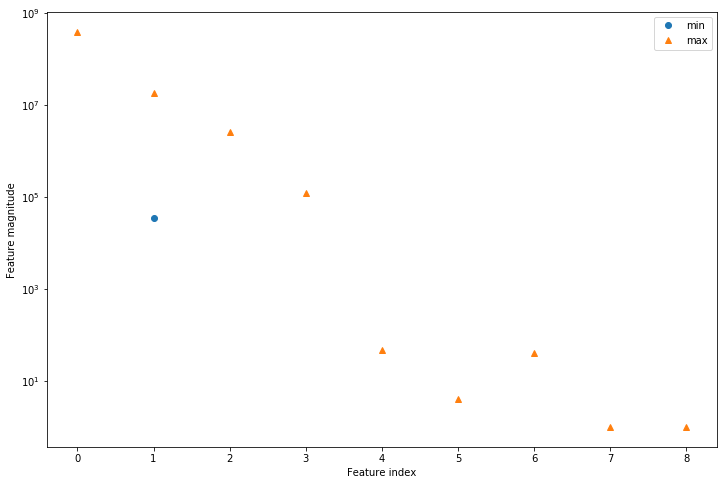

In [45]:
verifica_escala(variaveis_modelo,df)

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[variaveis_modelo].values)
x=scaler.transform(df[variaveis_modelo].values)
df_scaled=pd.DataFrame(x,columns=variaveis_modelo)
df_scaled.head()
#df_original=df.copy()
df=df_scaled.copy()

MinMaxScaler()

,VL_BENS,VR_DESPESA_CONTRATADA,followers_count,tweets,REQ,PEC,PL,MESA_Sim,LIDERANCA_Sim
0,0.022278,0.482061,0.002561,0.049669,0.395833,0.25,0.146341,0.0,1.0
1,0.003994,0.590963,0.567045,0.084516,0.062500,0.25,0.073171,0.0,0.0
2,0.007181,0.019148,0.053827,0.005454,0.000000,0.00,0.073171,0.0,0.0
3,0.007485,0.158104,0.165492,1.000000,0.000000,1.00,0.585366,0.0,1.0
4,0.003370,0.062998,1.000000,0.174101,0.458333,0.00,0.170732,0.0,0.0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VL_BENS                76 non-null     float64
 1   VR_DESPESA_CONTRATADA  76 non-null     float64
 2   followers_count        76 non-null     float64
 3   tweets                 76 non-null     float64
 4   REQ                    76 non-null     float64
 5   PEC                    76 non-null     float64
 6   PL                     76 non-null     float64
 7   MESA_Sim               76 non-null     float64
 8   LIDERANCA_Sim          76 non-null     float64
dtypes: float64(9)
memory usage: 5.5 KB


## Visualizando com PCA

In [48]:
x=df.values
variaveis=list(df.columns)

In [49]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components=3)
# fit PCA model 
pca.fit(x)
# transform data onto the first two principal components
x_pca = pca.transform(x)
print("Original shape: {}".format(str(x.shape)))
print("Reduced shape: {}".format(str(x_pca.shape)))
df_pca=pd.DataFrame(x_pca,columns=["PC-1","PC-2","PC-3"])

PCA(n_components=3)

Original shape: (76, 9)
Reduced shape: (76, 3)


Text(0.5, 0, 'First principal component')

Text(0.5, 0, 'Second principal component')

Text(0.5, 0, 'third principal component')

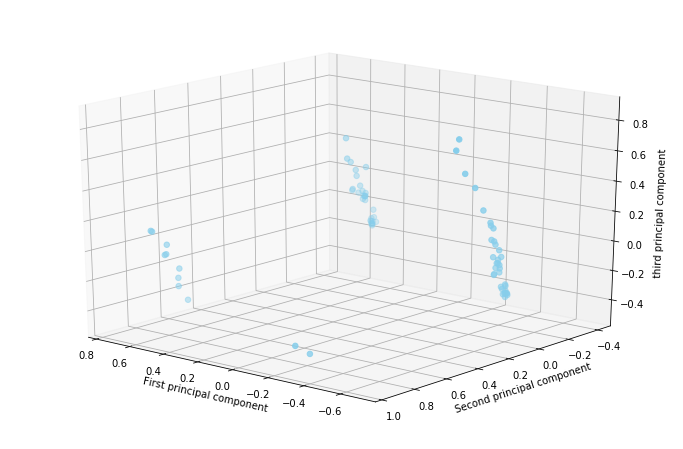

In [50]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PC-1'], df_pca['PC-2'], df_pca['PC-3'], c='skyblue', s=30)
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.set_zlabel("third principal component")
ax.view_init(20, 130)
plt.show()

PCA component shape: (3, 9)


,VL_BENS,VR_DESPESA_CONTRATADA,followers_count,tweets,REQ,PEC,PL,MESA_Sim,LIDERANCA_Sim
0,0.003537,0.025319,0.066384,-0.000379,-0.065075,-0.117420,-0.083544,0.280849,-0.943960
1,-0.046965,0.024968,0.017074,0.027761,0.014093,0.327243,0.271906,0.880735,0.197979
2,-0.003132,-0.028009,0.073117,0.229554,0.138850,0.766073,0.384262,-0.359240,-0.241468


<Figure size 864x144 with 0 Axes>

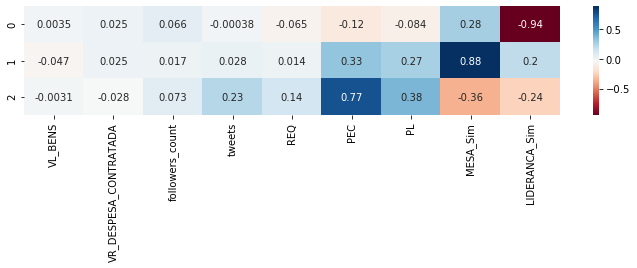

In [51]:
df_pca_componentes=pd.DataFrame(pca.components_, columns=variaveis)
print("PCA component shape: {}".format(df_pca_componentes.shape))
df_pca_componentes
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")
#(correlação,annot=True, vmin=-1, vmax=1)

In [52]:
def plot_pca_2d(x,y=True):
    plt.figure(figsize=(8, 8))
    if y.all():
        plt.scatter(x[:, 0], x[:, 1])
        plt.gca().set_aspect("equal")
    else:
        clusters = unique(y)
        for cluster in clusters:
            row_ix = where(y == cluster)
            # create scatter of these samples
            plt.scatter(x[row_ix, 0], x[row_ix, 1])
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")
    plt.legend(clusters, loc="best")
    plt.show()
    if clusters[0]==-1:
        quant=np.bincount(y+1)
    else:
        quant=np.bincount(y)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))
    

In [53]:
def plot_pca_3d(x,y=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if y.all():
        ax.scatter(x[:, 0], x[:, 1],x[:,2])
        ax.gca().set_aspect("equal")
    else:
        clusters = unique(y)
        for cluster in clusters:
            row_ix = where(y == cluster)
            # create scatter of these samples
            ax.scatter(x[row_ix, 0], x[row_ix, 1],x[row_ix, 2], s=20)
    ax.set_xlabel("PC-1")
    ax.set_ylabel("PC-2")
    ax.set_zlabel("PC-3")
    ax.legend(clusters, loc='upper left')
    ax.view_init(35, 120)
    plt.show()
    if clusters[0]==-1:
        quant=np.bincount(y+1)
    else:
        quant=np.bincount(y)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))
    

## ajustando variáveis

In [54]:
x=df.values

## K-mean


## Verificando o número de clusters via inércia

range(1, 50)

KMeans(n_clusters=1)

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

KMeans(n_clusters=5)

KMeans(n_clusters=6)

KMeans(n_clusters=7)

KMeans()

KMeans(n_clusters=9)

KMeans(n_clusters=10)

KMeans(n_clusters=11)

KMeans(n_clusters=12)

KMeans(n_clusters=13)

KMeans(n_clusters=14)

KMeans(n_clusters=15)

KMeans(n_clusters=16)

KMeans(n_clusters=17)

KMeans(n_clusters=18)

KMeans(n_clusters=19)

KMeans(n_clusters=20)

KMeans(n_clusters=21)

KMeans(n_clusters=22)

KMeans(n_clusters=23)

KMeans(n_clusters=24)

KMeans(n_clusters=25)

KMeans(n_clusters=26)

KMeans(n_clusters=27)

KMeans(n_clusters=28)

KMeans(n_clusters=29)

KMeans(n_clusters=30)

KMeans(n_clusters=31)

KMeans(n_clusters=32)

KMeans(n_clusters=33)

KMeans(n_clusters=34)

KMeans(n_clusters=35)

KMeans(n_clusters=36)

KMeans(n_clusters=37)

KMeans(n_clusters=38)

KMeans(n_clusters=39)

KMeans(n_clusters=40)

KMeans(n_clusters=41)

KMeans(n_clusters=42)

KMeans(n_clusters=43)

KMeans(n_clusters=44)

KMeans(n_clusters=45)

KMeans(n_clusters=46)

KMeans(n_clusters=47)

KMeans(n_clusters=48)

KMeans(n_clusters=49)

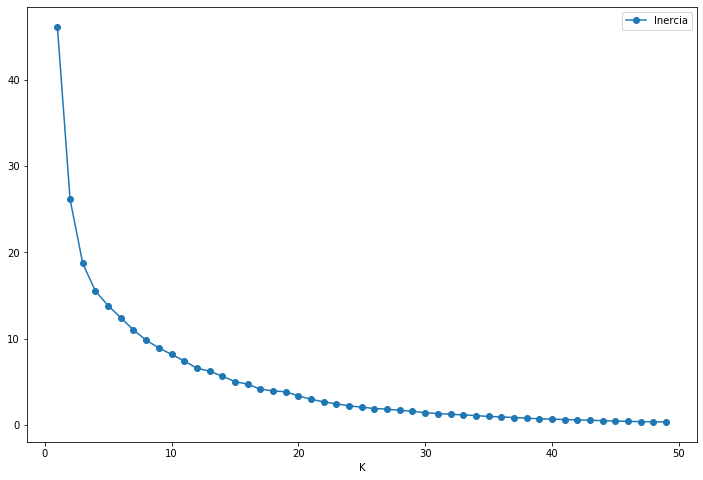

In [55]:
kvalues=range(1,50)
kvalues
inercia=[]
for k in kvalues:
    modelo=KMeans(n_clusters=k, init='k-means++')
    modelo.fit(x)
    inercia.append(modelo.inertia_)
df_inercia=pd.DataFrame({"Inercia":inercia, "K":kvalues}) 
df_inercia.plot("K","Inercia", marker='o')

In [56]:
# defining the kmeans function with initialization as k-means++
modelo = KMeans(n_clusters=6, init='k-means++')

# fitting the k means algorithm on scaled data
modelo.fit(x)
yhat = modelo.predict(x)
clusters = unique(yhat)
#print(variaveis_modelo)


KMeans(n_clusters=6)

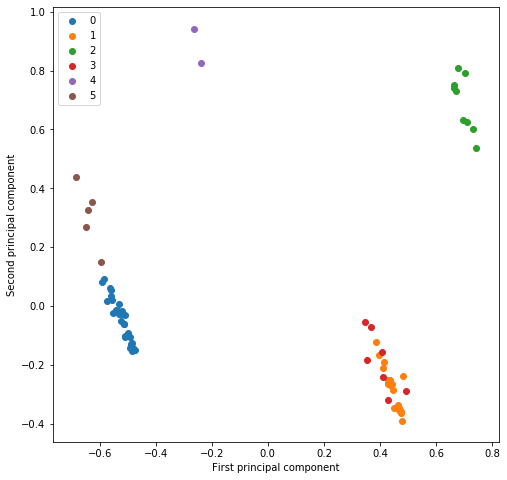

Número de componentes 
   cluster  quant
0        0     30
1        1     23
2        2      9
3        3      7
4        4      2
5        5      5


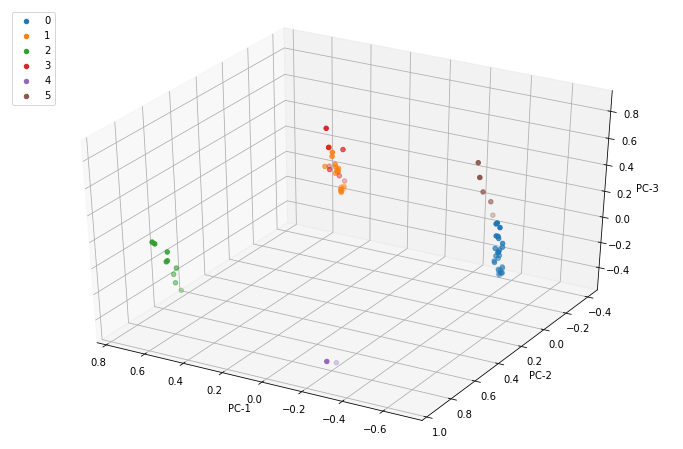

Número de componentes 
   cluster  quant
0        0     30
1        1     23
2        2      9
3        3      7
4        4      2
5        5      5


<Figure size 864x144 with 0 Axes>

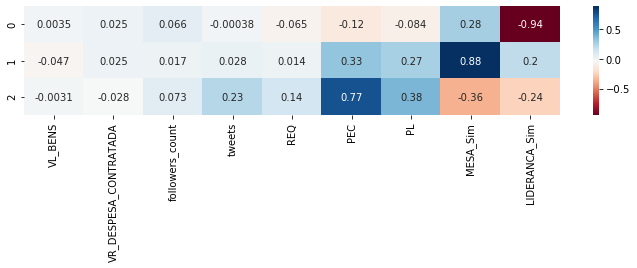

In [57]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [58]:
df_kmeans=df_original.copy()
df_kmeans["cluster"]=yhat
df_kmeans.sample(5)

,CPF,DT_NASCIMENTO,VL_BENS,NM_URNA_CANDIDATO,VR_DESPESA_CONTRATADA,followers_count,tweets,ID_SENADO,ID_PUB,MESA,...,REQ,PEC,PL,mandatos,cabeças,debatedor,articulador,formulador,negociador,cluster
15,00135968372,01/08/1942,1256546.67,ELMANO - O VEIN TRABALHADOR,2472971.60,0.0,0.0,5531,810,Não,...,3.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0
76,60838965172,01/06/1973,10000.00,SORAYA THRONICKE,74879.38,136081.0,3107.0,5988,854,Não,...,25.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0
71,18516440915,09/11/1950,1032616.41,FLAVIO ARNS,237324.76,9693.0,1027.0,345,856,Não,...,17.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,3
46,60232064253,07/07/1978,1301704.58,MARCOS ROGERIO,2063777.69,5467.0,1222.0,5422,868,Não,...,9.0,0.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,0
56,02382091304,09/06/1950,3962985.52,MARCELO CASTRO,1717161.23,3636.0,820.0,742,813,Não,...,6.0,1.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,1


## Mean-shift


In [59]:
from sklearn.cluster import MeanShift
modelo = MeanShift()
# fitting the k means algorithm on scaled data
modelo.fit(x)
yhat = modelo.predict(x)
clusters = unique(yhat)
#print(preditores)
clusters

MeanShift()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

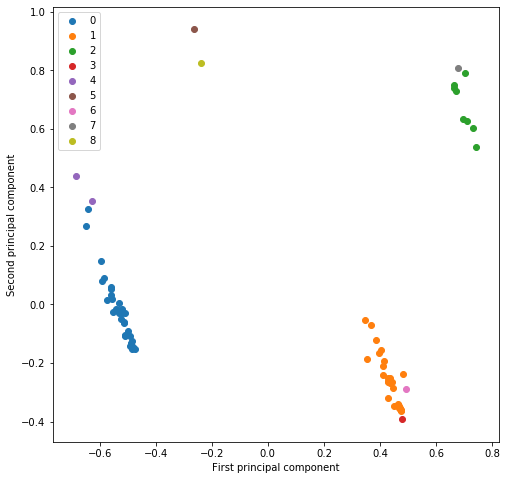

Número de componentes 
   cluster  quant
0        0     33
1        1     28
2        2      8
3        3      1
4        4      2
5        5      1
6        6      1
7        7      1
8        8      1


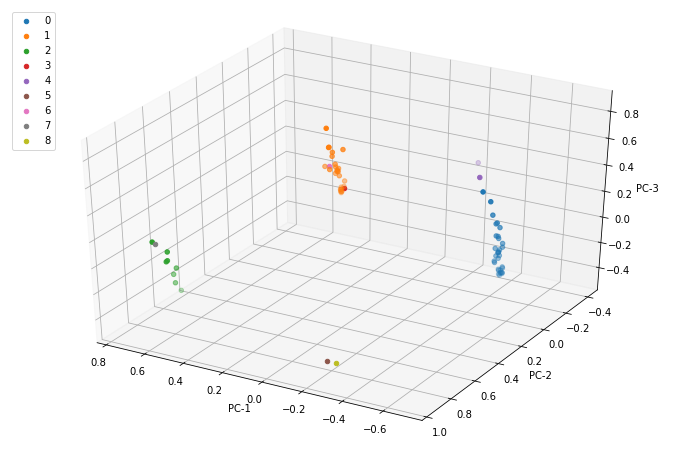

Número de componentes 
   cluster  quant
0        0     33
1        1     28
2        2      8
3        3      1
4        4      2
5        5      1
6        6      1
7        7      1
8        8      1


<Figure size 864x144 with 0 Axes>

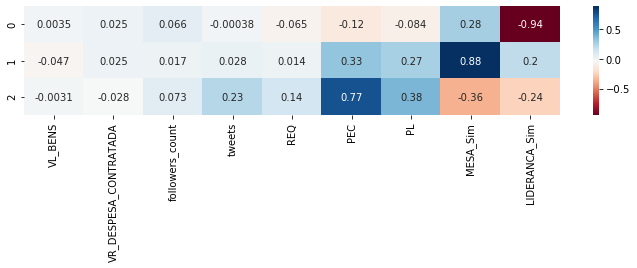

In [60]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [61]:
df_mean_s=df_original.copy()
df_mean_s["cluster"]=yhat
df_mean_s.sample(5)

,CPF,DT_NASCIMENTO,VL_BENS,NM_URNA_CANDIDATO,VR_DESPESA_CONTRATADA,followers_count,tweets,ID_SENADO,ID_PUB,MESA,...,REQ,PEC,PL,mandatos,cabeças,debatedor,articulador,formulador,negociador,cluster
48,31662625987,12/08/1945,2.397098e+08,PROFESSOR ORIOVISTO GUIMARAES,3376756.02,0.0,0.0,5924,857,Não,...,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
70,03733831187,16/05/1948,4.299775e+06,CONFUCIO MOURA,2345022.97,7997.0,11314.0,475,867,Não,...,8.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1
47,11218789204,08/02/1962,6.446377e+05,MECIAS DE JESUS,2237600.55,2255.0,1864.0,6027,881,Não,...,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0
49,41168720591,02/08/1968,3.500000e+04,ROGERIO CARVALHO SANTOS,1187810.90,0.0,0.0,5352,830,Não,...,31.0,1.0,14.0,1.0,1.0,1.0,0.0,0.0,0.0,0
27,77865111568,03/05/1958,5.666661e+06,ANGELO CORONEL,1509483.56,7129.0,2908.0,5967,832,Não,...,13.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [62]:
## DBSCAN

In [63]:
from sklearn.cluster import DBSCAN
modelo = DBSCAN(eps=0.5, min_samples=3)

In [64]:
modelo.fit(x)
yhat = modelo.fit_predict(x)
clusters = unique(yhat)
#print(preditores)
clusters

DBSCAN(min_samples=3)

array([-1,  0,  1,  2])

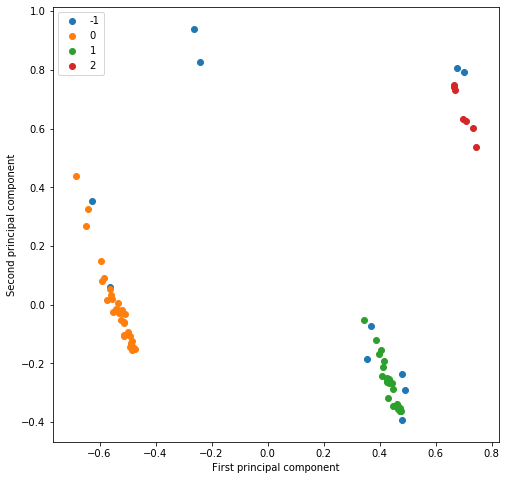

Número de componentes 
   cluster  quant
0       -1     11
1        0     33
2        1     25
3        2      7


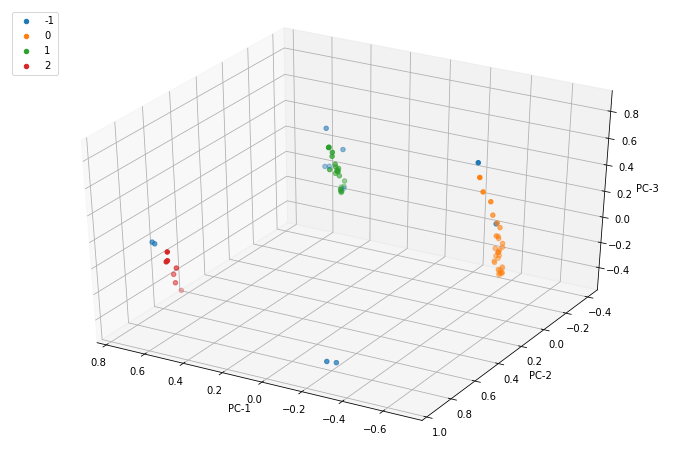

Número de componentes 
   cluster  quant
0       -1     11
1        0     33
2        1     25
3        2      7


<Figure size 864x144 with 0 Axes>

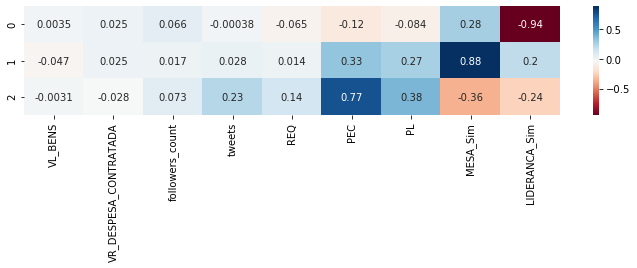

In [65]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [66]:
df_dbscan=df_original.copy()
df_dbscan["cluster"]=yhat
df_dbscan.sample(5)

,CPF,DT_NASCIMENTO,VL_BENS,NM_URNA_CANDIDATO,VR_DESPESA_CONTRATADA,followers_count,tweets,ID_SENADO,ID_PUB,MESA,...,REQ,PEC,PL,mandatos,cabeças,debatedor,articulador,formulador,negociador,cluster
71,18516440915,09/11/1950,1032616.41,FLAVIO ARNS,237324.76,9693.0,1027.0,345,856,Não,...,17.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1
64,00445689676,03/11/1976,22834764.00,RODRIGO PACHECO,3704500.34,11765.0,1936.0,5732,844,Não,...,5.0,0.0,11.0,1.0,2.0,0.0,1.0,0.0,0.0,0
51,21840571187,20/01/1961,95000.00,JORGE KAJURU,209591.06,274458.0,59703.0,5895,863,Não,...,10.0,2.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
50,20912340282,10/11/1964,159860.00,LUCAS BARRETO,479925.55,1942.0,53.0,5926,905,Não,...,2.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,37967517768,23/01/1949,988566.00,ROSE DE FREITAS,4973756.92,20257.0,4611.0,2331,901,Não,...,5.0,4.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## GMM

In [67]:
from sklearn.mixture import GaussianMixture
modelo = GaussianMixture(n_components=5)
modelo.fit(x)
yhat = modelo.predict(x)

GaussianMixture(n_components=5)

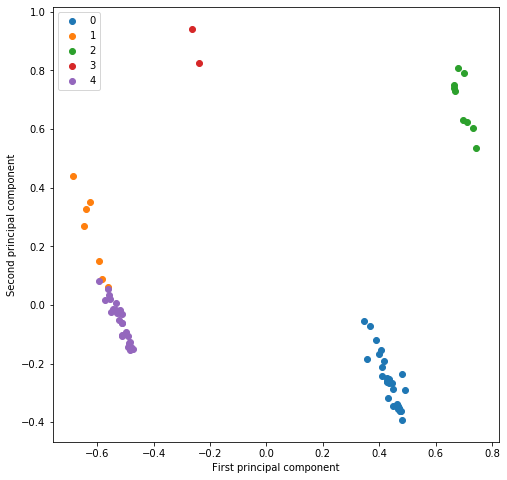

Número de componentes 
   cluster  quant
0        0     30
1        1      7
2        2      9
3        3      2
4        4     28


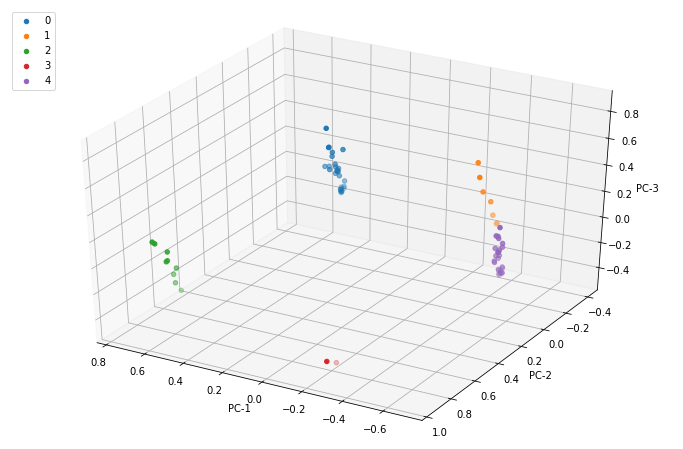

Número de componentes 
   cluster  quant
0        0     30
1        1      7
2        2      9
3        3      2
4        4     28


<Figure size 864x144 with 0 Axes>

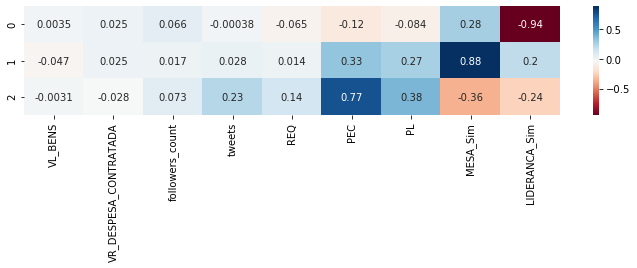

In [68]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_GMM=df_original.copy()
df_GMM["cluster"]=yhat
df_GMM.sample(5)

## Aglomerative H Cluster

In [ ]:
from sklearn.cluster import AgglomerativeClustering
modelo = AgglomerativeClustering(n_clusters=5)
yhat = modelo.fit_predict(x)
clusters = unique(yhat)

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
#df_HC=df_original.copy()
df_HC=df.copy()
df_HC["cluster"]=yhat
df_HC.sample(5)

## creating a distance matrix using linkage

In [ ]:
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Use the linkage() function
distance_matrix = linkage(x,method = 'ward', metric = 'euclidean') # method = 'single'/'complete'

# Assign cluster labels
#comic_con['cluster_labels'] = fcluster(distance_matrix, 2, criterion='maxclust')
dendrogram(distance_matrix)

In [ ]:
#dendrogram(distance_matrix)
# Use fcluster to extract labels: labels
clusters = fcluster(distance_matrix, 1.6, criterion='distance' )
df_ch=df_original.copy()
df_ch["cluster"]=clusters
df_ch.head(5)

# Avaliação com ARI Adjusted Rand Score Index

In [ ]:
# adjusted rand score is 1, as the clustering is exactly the same
# df_kmeans, df_mean_s, df_dbscan, df_GMM, df_HC, df_ch

In [ ]:
from sklearn.metrics import adjusted_rand_score
target=df_HC
lista=[df_kmeans,df_mean_s,df_dbscan,df_GMM,df_HC,df_ch]

for df in lista:
    print("ARI: {:.2f}".format(adjusted_rand_score(target["cluster"].values, df["cluster"].values)))


## EDA com K-mean

In [ ]:
df=df_HC.copy()

## EDA Básico

In [ ]:
df.info()
df.describe().round(2)

In [ ]:
#df.fillna(0, inplace=True)
#df.info()

In [ ]:
df.describe(include=np.object)

In [ ]:
df.info()
unicos=df.nunique()
unicos

## Defindo variaveis categóricas numericas

In [ ]:
def analisa_variaveis(df,variaveis,nunicas):
    lista=[]
    unicos=df[variaveis].nunique()
    for variavel in unicos.index:
        quant=unicos.loc[variavel]
        if quant <= nunicas:
            lista.append(variavel)
            print("Variavel {}, {} ocorrências únicas".format(variavel,quant))
            print(df[variavel].sort_values().unique())
    return lista

In [ ]:
variaveis_numericas= df.select_dtypes(include=[np.number]).columns
variaveis_categoricas= df.select_dtypes(include="category").columns
df[variaveis_numericas].info()
df[variaveis_categoricas].info()

In [ ]:
variaveis_objeto=df.select_dtypes(include="object").columns
df[variaveis_objeto].info()

### Histogramas

In [ ]:
for variavel in variaveis_categoricas:
    df[variavel].value_counts().plot(kind="bar")
    plt.xlabel(variavel)
    plt.ylabel("Contagem")
    plt.title(variavel)
    plt.show()

### Boxplots - Identificando, verificando e tratando outliers


In [ ]:
for cat in variaveis_categoricas:
    for num in variaveis_numericas:
        sns.boxplot(x=cat, y=num, data=df)
        plt.xlabel(cat)
        plt.ylabel(num)
        plt.title(cat)
        plt.show()


In [ ]:
df.info()

In [ ]:
variaveis=list(variaveis_numericas)+list(variaveis_categoricas)
variaveis.remove("cluster")
preditores=variaveis
target=["cluster"]
variaveis=["cluster"]+variaveis
variaveis

In [ ]:

df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")

correlação=df[variaveis].corr()
correlação
plt.rc('figure', figsize=(12, 8))
sns.heatmap(correlação,annot=True, vmin=-1, vmax=1)

In [ ]:
sns.pairplot(df[variaveis], kind="scatter")

In [ ]:
sns.pairplot(df, y_vars=target, x_vars=preditores, hue=target[0])